# Loading Library

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'

import warnings
warnings.filterwarnings("ignore")
#from sklearn.utils.testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning

from scipy.stats.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

from sklearn.ensemble import IsolationForest
SHOW_PLOTS = True
                                                                                                                                                        
# Make True to see feature importance graphs
SHOW_FEATURE_IMPORTANCE = True

In [8]:
from pandas_profiling import ProfileReport

In [9]:
data=pd.read_csv('Load.txt', sep='\t', header=0, names=["Timestamp", "Load", "temperature"])

In [10]:
profile = ProfileReport(data, title="Pandas Profiling Report")

In [12]:
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
data

,Timestamp,Load,temperature
0,2016-01-01T00:00,10320,6.98
1,2016-01-01T01:00,10400,3.62
2,2016-01-01T02:00,10280,6.87
3,2016-01-01T03:00,10160,6.77
4,2016-01-01T04:00,9840,6.66
...,...,...,...
125,2016-01-06T05:00,14800,-6.87
126,2016-01-06T06:00,15880,-6.91
127,2016-01-06T07:00,17640,-7.31
128,2016-01-06T08:00,18280,-6.91


# data processing and data cleaning

after loading the data our next step is to clean the data like remove outliers ,null values and unwanted
data values

In [4]:
data.isna().sum()

Timestamp      0
Load           0
temperature    0
dtype: int64

In [5]:
len(data)

130

now from above we see that there is no null values present into it , so our next step is check for outliers in data

In [13]:
data.set_index(pd.date_range(start='2016/01/01', periods=130, freq='H'), inplace=True)

taking useful amount of data from given dataset

In [14]:
data_u=data[['temperature']]

In [15]:
data_u

,temperature
2016-01-01 00:00:00,6.98
2016-01-01 01:00:00,3.62
2016-01-01 02:00:00,6.87
2016-01-01 03:00:00,6.77
2016-01-01 04:00:00,6.66
...,...
2016-01-06 05:00:00,-6.87
2016-01-06 06:00:00,-6.91
2016-01-06 07:00:00,-7.31
2016-01-06 08:00:00,-6.91


<AxesSubplot:>

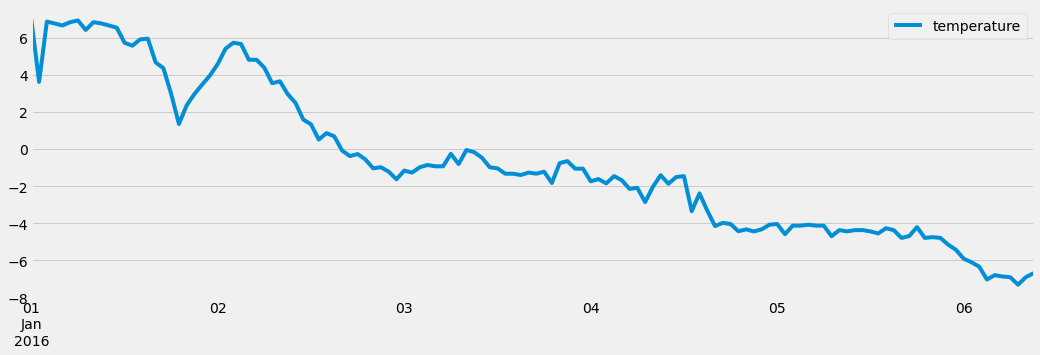

In [16]:
data_u[['temperature']].plot(figsize=(16,5))

Text(0, 0.5, 'time')

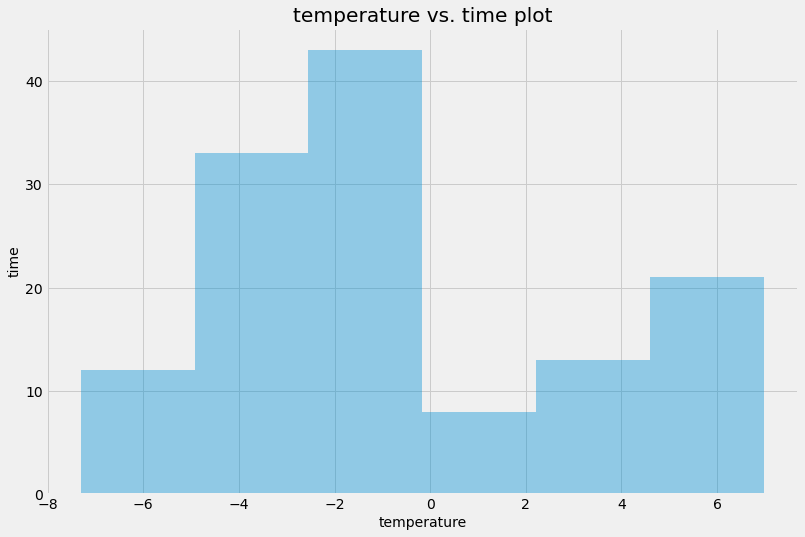

In [17]:
import seaborn as sns
plt.figure(figsize = (12,8))
sns.distplot(data_u['temperature'], kde=False)
plt.title('temperature vs. time plot')
plt.xlabel('temperature')
plt.ylabel('time')

so from above see that there is no outliers in given data so we start for building of machine learning
model

Here we build differnt machine learning model for forecasting our data for next hours

## smooth data for outlier removal

In [18]:
# smooth out anomalies
def smooth(full_data):
    for i in full_data.columns:
        if MODELS[i][0].startswith('SARIMAX'):
            full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=False)
 
    return full_data


def outlier_smoothing(X, contamination=0.15, smoothing_window=4, plot=True, random_state=22, verbose=True):
    """
    Outlier identification by IForest and 
    smoothing by rolling window median value
    """
    X_rolling_median = X.rolling(smoothing_window).median()
    X_rolling_mean = X.rolling(smoothing_window).mean()
    X_smoothing_ratio = X / X_rolling_median

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_rolling_median, label='rolling median')
        plt.title("Original vs. Rolling Median")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,10))
        plt.plot(X.index, X_smoothing_ratio, label="original:smoothing ratio")
        plt.title("Smoothing Ratio")
        plt.legend()
        plt.show()
    
    ## Find the outliers
    iso_forest = IsolationForest(contamination=contamination,\
        random_state=random_state)
    peaks = np.where(iso_forest.fit_predict(X_smoothing_ratio[smoothing_window-1:].\
        values.reshape(-1,1))<1)
    if verbose:
        print("Outliers found at ", X.index[peaks[0]+smoothing_window-1])
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index.values[peaks[0]+smoothing_window-1],\
            X.values[peaks[0]+smoothing_window-1], 'x'
            )
        plt.title("Outlier Finders")
        plt.legend()
        plt.show()
    ## Change the outliers with corresponding smoothed values    
    X_smoothed = X.copy()

    for i in range(len(X)):
        if np.any(peaks[0]+smoothing_window-1==i):
            X_smoothed[i] = X_rolling_mean[i]

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_smoothed, label='smoothed')
        plt.title("Original vs. smoothed")
        plt.legend()
        plt.show()
    
    return X_smoothed



#Quantitative Scoring using MAPE
def MAPE(gt, pred):
    mape = []

    for g, p in zip(gt, pred):
        mape.append(max(0, 1 - abs((g-p)/g)))

    return np.mean(mape)


def Max_APE(gt, pred):
    """
    Returns max absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(y_true, y_pred):
    """
    Returns root mean square error
    """
    return sqrt(mean_squared_error(y_true, y_pred))


import itertools
import statsmodels.api as sm
# this function is for selection of best parameter in sarimax model , like order and seasonal_order
def best_parameters_sarimax(series, exog=None):
    '''
    Finds the best parameters for a given series for SARIMAX algorithm.
    Input: series: the series for which the parameters are to be determined.
            exog: extra features to be considered
    Output: the best parameters for the series and model.
    return (1, 1, 1), param_seasonal
    '''
    #return (1, 1, 1)
#, param_seasonal
    #param=(1,1,1)
    result_param = -1
    result_param_seasonal = -1
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                try:
                    if results.aic < minimum:
                        result_param = param
                        result_param_seasonal = param_seasonal
                except:
                    result_param = param
                    result_param_seasonal = param_seasonal
                    minimum = results.aic
            except:
                continue
    print(result_param, result_param_seasonal)
    return result_param, result_param_seasonal

def apply_model_sarimax(series, best_param, best_param_seasonal):

    
    mod = sm.tsa.statespace.SARIMAX(series,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    return results

def create_dataset(dataset, look_back=1):
    '''
    Convert an array of values into a dataset matrix
    Input: Array data
    Output: reshape into X=t, Y=t+1 (the next timestamp)
    '''
    dataset = dataset.reshape(dataset.shape[0], 1)
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## MODELS FOR FORECASTING

In [3]:
#@ignore_warnings(category=ConvergenceWarning)
def cross_validation_and_model_comparison(train_df, number_of_steps_to_predict):
    print('LSTM')
    look_back = 24
    units = 50      
    trainX, trainY = create_dataset(train_df.values, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    model = Sequential()
    model.add(LSTM(units=units, return_sequences= True,input_shape=( 1,look_back)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=300, batch_size=20, verbose=0)

    testX = np.array([trainY[-look_back:]])

    forecast = []
    for i in range(0,number_of_steps_to_predict):
        testX = np.reshape(testX, (testX.shape[0], 1, look_back))
        testPredict = model.predict(testX)
        testX = np.roll(testX, -1)
        testX[0][0][look_back - 1] = testPredict[0][0]

        forecast.append(testPredict[0][0])

    return forecast

In [4]:
def make_predictions(target_data):
    train_df=target_data
    #change the number of steps of how much day you want
    number_of_steps=12
    forecast=cross_validation_and_model_comparison(train_df,number_of_steps)
    return forecast

In [5]:
if __name__ == '__main__':
    
    print('Reading files')
    
    print('Finding related features')
#     related_features = find_correlated_features(target_data, target_data)
    related_features = None
    
    print('Making full forecast')
    full_forecasts = make_predictions(data_u)

Reading files
Finding related features
Making full forecast


NameError: name 'data_u' is not defined

here we make the output data to save in date format ,so for this we make function , in this function we
simply pass output list from above main function

In [1]:
def make_final_data(list1):
    temp=pd.DataFrame()
    temp['time']=pd.date_range(start='2016/01/06 10:00', periods=12, freq='H')
    temp['temperature(LSTM)']=list1
    return temp

In [221]:
sub

,time,temperature(LSTM)
0,2016-01-06 10:00:00,-6.399888
1,2016-01-06 11:00:00,-5.875906
2,2016-01-06 12:00:00,-4.921003
3,2016-01-06 13:00:00,-4.238464
4,2016-01-06 14:00:00,-3.728727
5,2016-01-06 15:00:00,-3.535289
6,2016-01-06 16:00:00,-3.401476
7,2016-01-06 17:00:00,-3.335377
8,2016-01-06 18:00:00,-3.314272
9,2016-01-06 19:00:00,-3.264025


## plotting of output result 

<AxesSubplot:xlabel='time'>

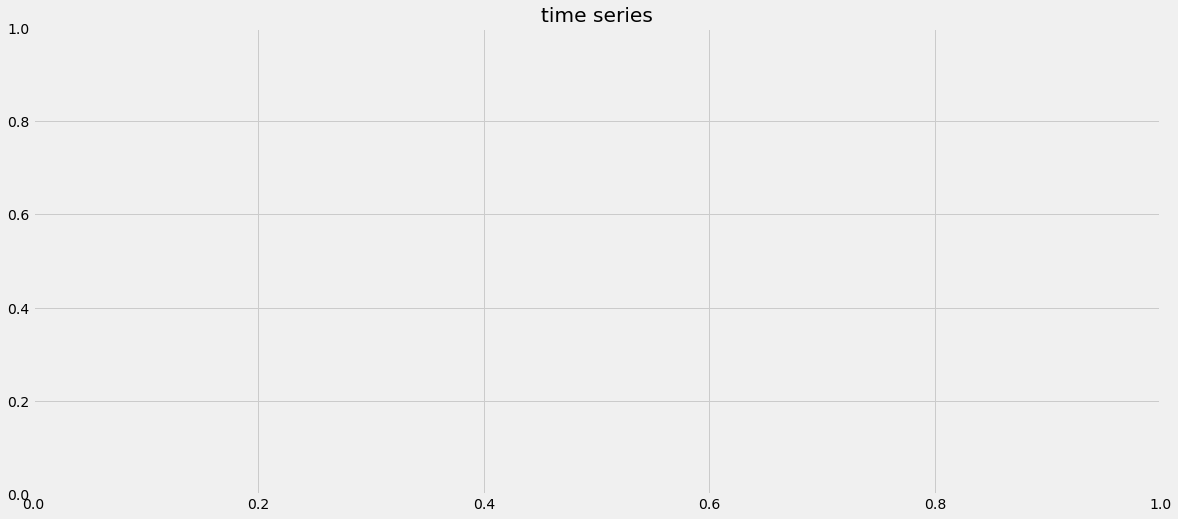

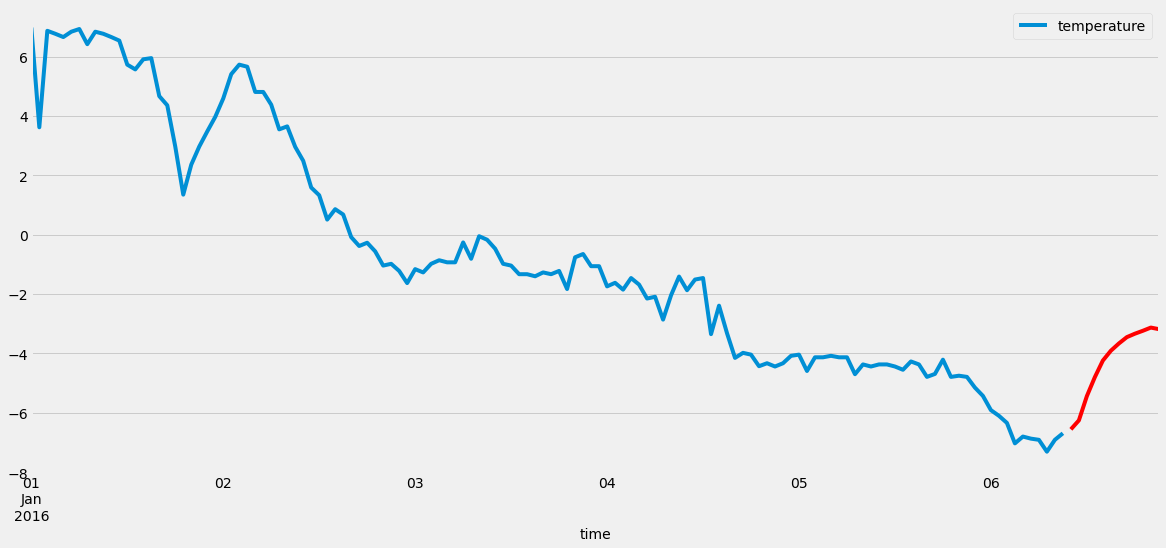

In [24]:
matplotlib.rcParams['figure.figsize'] = 18, 8
plt.figure()
plt.title('time series')
data_u.plot()
sub.index = sub['time']
sub['temperature(LSTM)'].plot(color='red')
#plt.savefig('images/foracast {0}.jpg'.format(i[24:]))

## forecasting using SARIMAX model

sarimax model is widly used in time series forecasting , to get complete study of sarimax i will 
attach  the link below
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

here the seletction of order, seasonal_order parameter is done by hyperparameter tunning and some 
mathematical equation that is very interesting topic

In [25]:
model=sm.tsa.statespace.SARIMAX(data_u['temperature'],order=(1,1,1),seasonal_order=(1,1,2,24))
model_fit=model.fit()

In [26]:
ll=model_fit.predict(start=130,end=141,dynamic=False)

In [27]:
ll

2016-01-06 10:00:00   -6.976732
2016-01-06 11:00:00   -6.932610
2016-01-06 12:00:00   -6.934179
2016-01-06 13:00:00   -7.905054
2016-01-06 14:00:00   -7.380508
2016-01-06 15:00:00   -7.855819
2016-01-06 16:00:00   -8.323324
2016-01-06 17:00:00   -8.222902
2016-01-06 18:00:00   -8.015253
2016-01-06 19:00:00   -8.468214
2016-01-06 20:00:00   -8.230364
2016-01-06 21:00:00   -8.282563
Freq: H, Name: predicted_mean, dtype: float64

In [28]:
sub['temperature(SARIMA)']=ll

In [29]:
sub

,time,temperature(LSTM),temperature(SARIMA)
time,,,
2016-01-06 10:00:00,2016-01-06 10:00:00,-6.556610,-6.976732
2016-01-06 11:00:00,2016-01-06 11:00:00,-6.254897,-6.932610
2016-01-06 12:00:00,2016-01-06 12:00:00,-5.437135,-6.934179
2016-01-06 13:00:00,2016-01-06 13:00:00,-4.796764,-7.905054
2016-01-06 14:00:00,2016-01-06 14:00:00,-4.239327,-7.380508
2016-01-06 15:00:00,2016-01-06 15:00:00,-3.908173,-7.855819
2016-01-06 16:00:00,2016-01-06 16:00:00,-3.664302,-8.323324
2016-01-06 17:00:00,2016-01-06 17:00:00,-3.450540,-8.222902
2016-01-06 18:00:00,2016-01-06 18:00:00,-3.335028,-8.015253


<AxesSubplot:xlabel='time'>

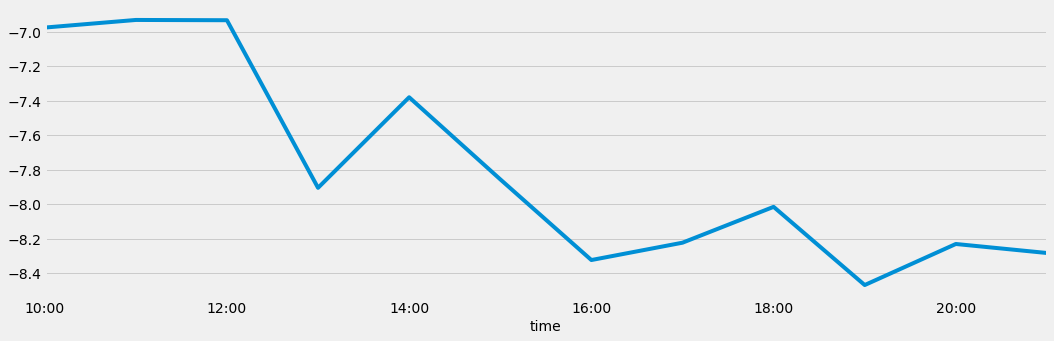

In [30]:
sub['temperature(SARIMA)'].plot(figsize=(16,5))

## saving forecasted notebook to csv file

In [31]:
sub.to_csv('forecasted.csv', index=False)

In [32]:
sub.to_csv('forecasted.txt', index=False, sep=' ')

                            ### Thank you

## 24 hours daily data plot

now we work on 24 hourly data plot 

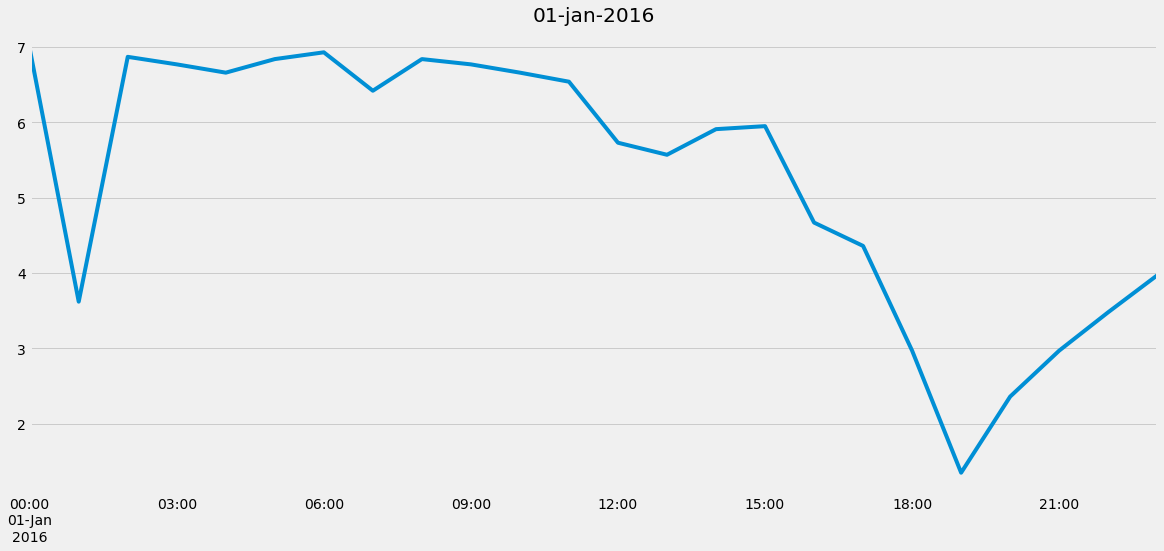

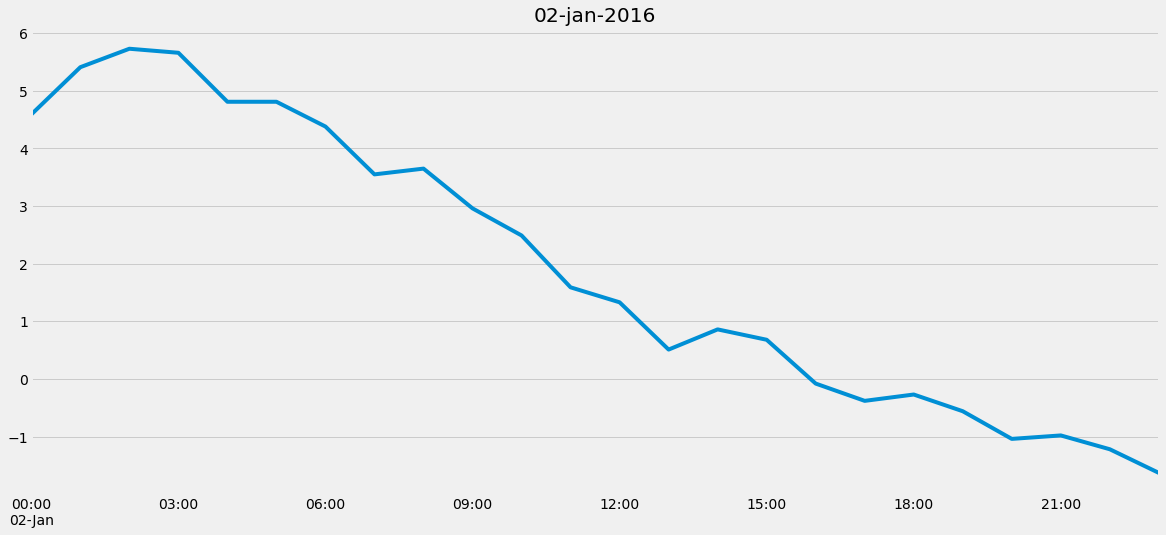

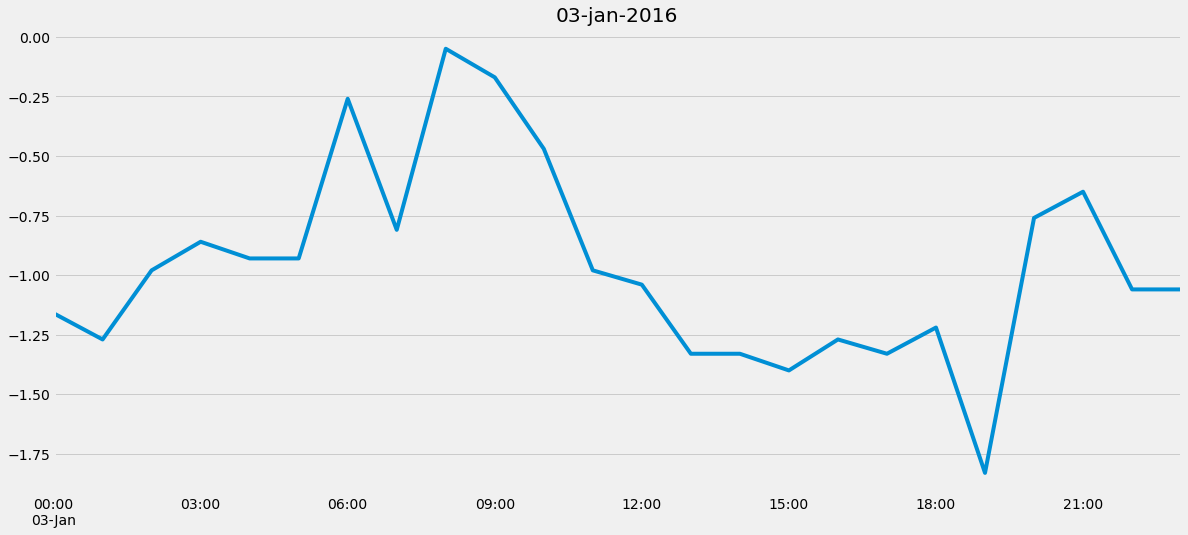

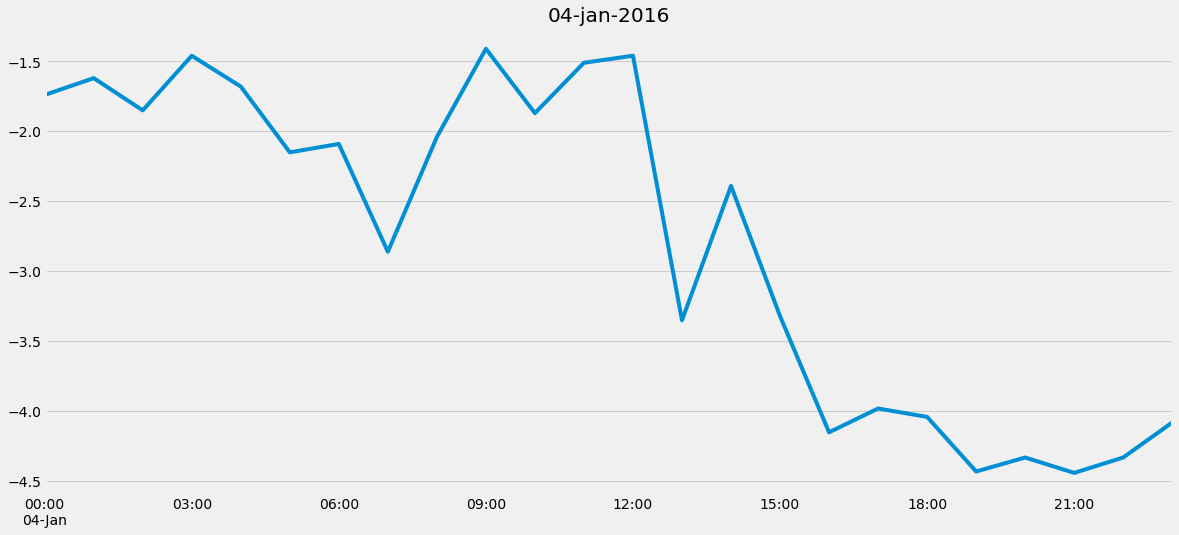

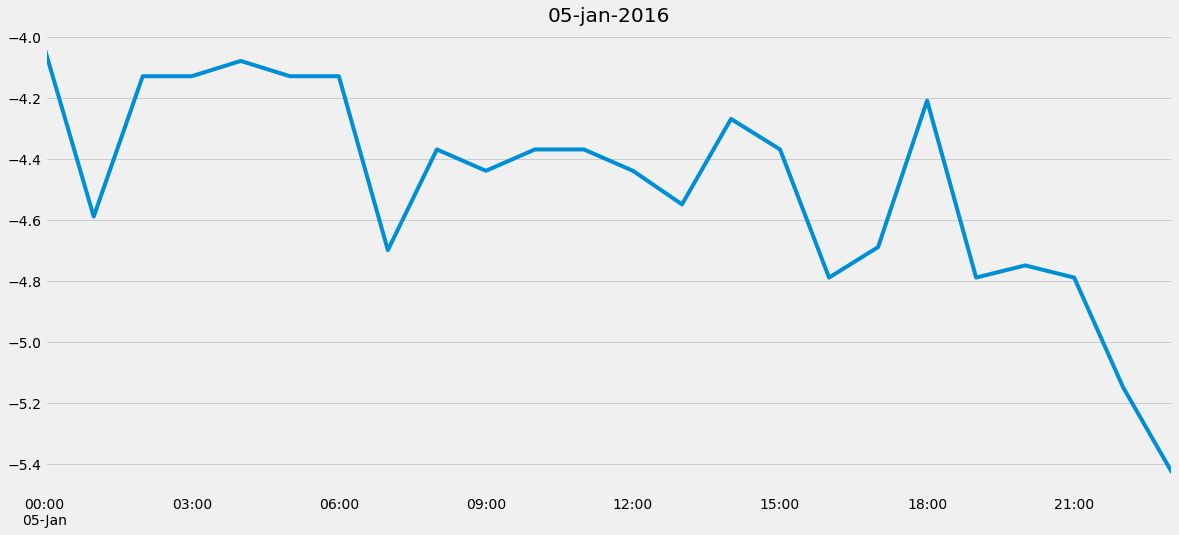

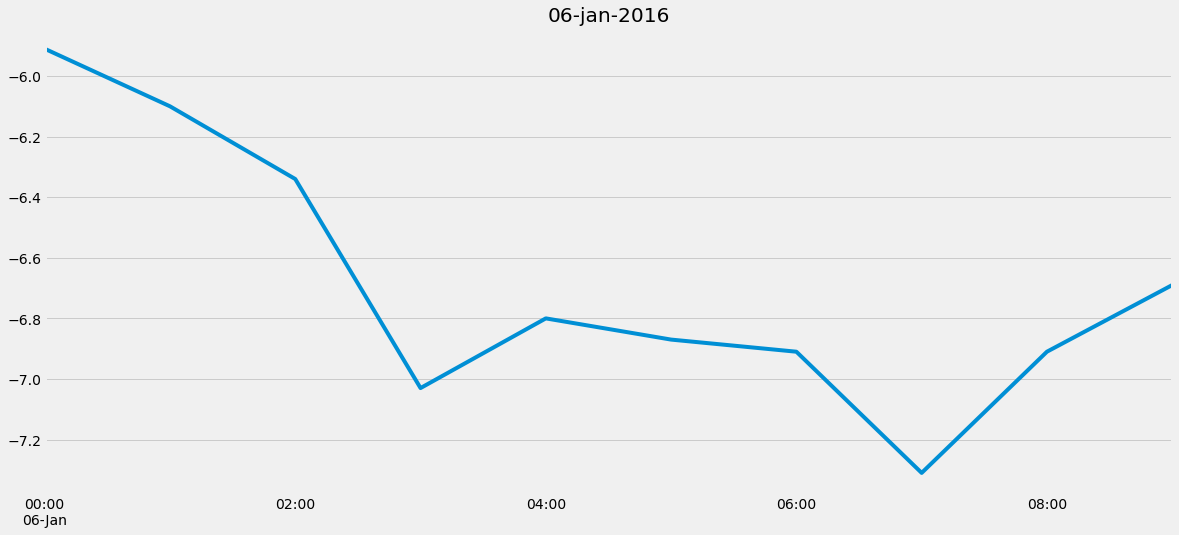

In [46]:
#for 24 hourly data plot
date_1=['01-jan-2016','02-jan-2016','03-jan-2016','04-jan-2016','05-jan-2016','06-jan-2016']
for i in range(0,6):
    plt.figure()
    plt.title(date_1[i])
    data_u['temperature'][24*i:24*(i+1)].plot()
